<a href="https://colab.research.google.com/github/aghapygad336/Image-Segmentation/blob/master/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from urllib.request import urlretrieve
import cv2
import os
import glob
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.metrics.cluster import contingency_matrix
import math
from PIL import Image
from matplotlib import *
import random
from sklearn.metrics import pairwise_distances

from sklearn.cluster import SpectralClustering





In [0]:
if not os.path.isfile('BSR_bsds500.tgz'):
    urlretrieve('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz','BSR_bsds500.tgz')
if not os.path.isfile('content/BSR_bsds500.tgz'):
    !apt-get install p7zip-full
    !p7zip -d BSR_bsds500.tgz
    !tar -xvf BSR_bsds500.tgz

In [0]:

imagesFile_path = "BSR/BSDS500/data/images/train/"
imagesFile = [f for f in listdir(imagesFile_path) if isfile(join(imagesFile_path, f)) and f.endswith(".jpg")]
sortedImgfiles=sorted(imagesFile)

In [0]:



data = []

for i in range(len(sortedImgfiles)):
    testPlot=imagesFile_path+sortedImgfiles[i]
    img = cv2.imread(testPlot, cv2.IMREAD_UNCHANGED)

# get dimensions of image
    dimensions = img.shape
# height, width, number of channels in image
    height = img.shape[0]
    width = img.shape[1]
    channels = img.shape[2]
    numberTotalPixels=height*width
    data.append(img)
    mydata = np.array(data)

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)
print('Number of Pixels   : ',numberTotalPixels)


In [0]:
chsenNumbers=15
plt.imshow(mydata[chsenNumbers])
plt.show()


**Extract Ground Truth**

In [0]:
groundTruth_path = "BSR/BSDS500/data/groundTruth/train/"
groundTruthFile = [f for f in listdir(groundTruth_path) if isfile(join(groundTruth_path, f)) and f.endswith(".mat")]
sortedGroundTruthFile=sorted(groundTruthFile)

In [0]:
import scipy.io 

def load_bsd_gt(filename):
    gt = scipy.io.loadmat(filename);
    # scipy.io.loadmat()
    gt = gt['groundTruth']
    what = ['Segmentation','Boundaries']
    cols = (gt.shape[1])
    ret = list()
    for xx in range(cols):
        j=0
        tmp = list()
        for w in what:
            tmp.append(gt[0][xx][w][0][0][:])
            arr_gt=np.array(tmp[j])
            print(arr_gt.shape)
            j=j+1
            plt.imshow(arr_gt)
            plt.show()
            ret.append(tmp)
    return ret



In [0]:
arr_gt=[]
testPlot_=groundTruth_path+sortedGroundTruthFile[Picture_numbr]
arr_gt=load_bsd_gt(testPlot_)


 ***Color Quantization*** is the process of reducing number of colors in an image. One reason to do so is to reduce the memory. Sometimes, some devices may have limitation such that it can produce only limited number of colors. In those cases also, color quantization is performed. Here we use **k-means clustering for color quantization**. italicized text

**`K-Means`**


param clusters: cluster dicts in the form center:(colors)
return: the clusters after convergence is reached


In [0]:


def change_clusters_if_needed(clusters, image):
 
  new_centers = []
  something_changed = False
  for center in clusters:
    colors = clusters[center]
    average = get_average_color(colors)
    if average != center:
      something_changed = True
    new_centers.append(average)
  if something_changed:
    new_empty_clusters = create_cluster_dict(new_centers)
    new_populated_clusters = populate_clusters(image, new_empty_clusters, new_centers)
    return change_clusters_if_needed(new_populated_clusters, image)
  else:
    return clusters




Param colors: a list of colors in the form (R, G, B)
return: a color in the form (R, G, B)
  

In [0]:


def get_average_color(colors):

  num_colors = len(colors)
  if num_colors == 0:
    return (0, 0, 0)
  r, g, b = 0, 0, 0
  for color in colors:
    r += color[0]
    g += color[1]
    b += color[2]
  return(int(r/num_colors), int(g/num_colors), int(b/num_colors))



The image for which we are creating the clusters, default cluster dict where the key is the center and the value is the list of colors in the cluster centers: a list of the colors that we are using to cluster return: the cluster dict after populating with colors in the image


In [0]:



def populate_clusters(image, clusters, centers):

  for y in range(image.height):
    for x in range(image.width):
      color = image.getpixel((x, y))
      center = get_nearest_center(color, centers)
      clusters[center].append(color)
  return clusters



param color: a color in the form (R, G, B) , centers: a list of colors
return: the center that is closet to color according to distance between colors


In [0]:

def get_nearest_center(color, centers):
 
  nearest_center = centers[0]
  shortest_distance = distance_between_colors(color, centers[0])
  for c in centers[1:]:
    distance = distance_between_colors(color, c)
    if distance < shortest_distance:
      shortest_distance = distance
      nearest_center = c
  return nearest_center


param image: the image in which we are getting n random pixels,n: the number of random pixels return: a list of n pairs, each of which contains an (x, y) coordinate


In [0]:


def get_random_colors(image, n):
  
  initial_colors = []
  while(len(initial_colors) < n):
    x = random.randint(0, image.width)
    y = random.randint(0, image.height)
    color = image.getpixel((x, y))
    initial_colors.append(color)
  return initial_colors




param color1: a color in the format (R, G, B) color2: a color in the format (R, G, B)return: a floating point number representing the color space distance between color1 and color2


In [0]:

def distance_between_colors(color1, color2):

  sum = 0
  for index in range(3):
    sum += (color1[index] - color2[index])**2
  return sum ** (1/2)


param image: a blank image whose pixels' colors will be set, clusters: the groups of similar pixels in a dict object return: nothing, this function edits 'image'

In [0]:


def populate_image_from_clusters(image, clusters):

  centers = list(clusters.keys())
  for y in range(image.height):
    for x in range(image.width):
      old_color = image.getpixel((x, y))
      closest_center = get_nearest_center(old_color, centers)
      image.putpixel((x, y), closest_center)



In [0]:
def create_cluster_dict(centers):
  d = {}
  for c in centers:
    d[c] = []
  return d

In [0]:
def main_Kmeans(Picture_numbr):
    testPlot=imagesFile_path+sortedImgfiles[Picture_numbr]

    filename = testPlot
    input_image = Image.open(filename)
    data_new_image=[]
    data_final_clusters=[]
    Kmeans_=[3,5,7,9,11]
    for k in Kmeans_:  
  
        input_image = Image.open(filename)
        default_colors = get_random_colors(input_image,k)
        default_cluster = create_cluster_dict(default_colors)
        clusters = populate_clusters(input_image, default_cluster, default_colors)
        final_clusters = change_clusters_if_needed(clusters, input_image)
        new_image = input_image.copy()
        populate_image_from_clusters(new_image, final_clusters)
        data_new_image.append(new_image)
        data_final_clusters.append(final_clusters)
        print("For K =",k)
        plt.imshow(new_image)
        plt.show() 
    
    return data_new_image,data_final_clusters

For K = 11


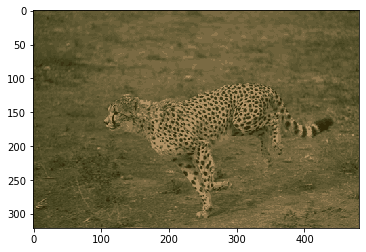

In [76]:
DataKmean,data_final_clusters=main_Kmeans(Picture_numbr)

# Converting Gray Scale
convert  RGB Clustered Image to Grey Scale to be easy For Measuring Accuracy

In [0]:
def convertGray(DataKmean):
    kmeanClustered=[]
    for i in range(0,5):  
        a = np.array(DataKmean[i].getdata()).astype(np.float32).reshape((DataKmean[i].size[1],DataKmean[i].size[0],3) )
        gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
        p=np.ceil(gray)
        plt.imshow(p)
        kmeanClustered.append(p)
        plt.show()
        print(i)
    return kmeanClustered
    


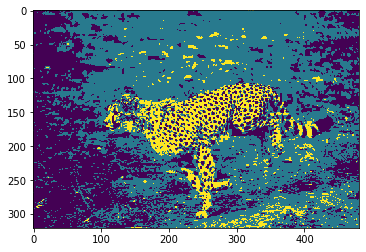

0


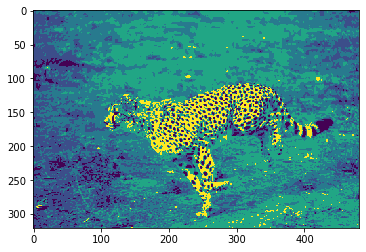

1


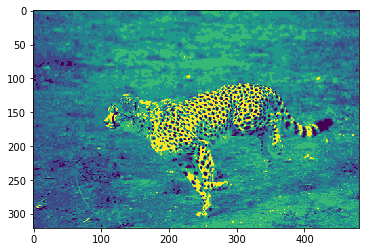

2


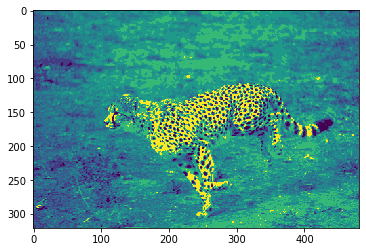

3


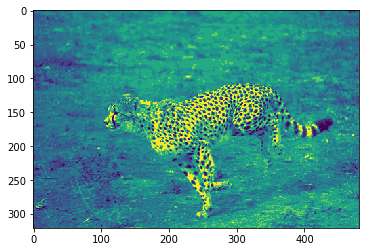

4


In [78]:
kmeanClustered=convertGray(DataKmean)

In [0]:
from sklearn.metrics.cluster import contingency_matrix
def fmeasure (i_Kmean,kmeanClustered,arr_gt):
    j_2D=[0,1]
    fScore=[]
    Kmeans_=[3,5,7,9,11]

    for i_ in i_Kmean:
        for j in j_2D:
            true_ = kmeanClustered[i_].flatten()
            prediction_ = arr_gt[i_][j].flatten()
            cont = contingency_matrix(prediction_, true_)
            contingency = cont.T
            Actual_P = np.sum(contingency,axis=0)
            Actual_N = np.sum(contingency,axis =1)
            prec = []
            recall =[]
            count = 0
            for i in contingency:
                prec = np.append(prec,(max(i)/Actual_N[count]))
                recall = np.append(recall,(max(i)/Actual_P[np.argmax(i)]))
                count+=1
            f1_measure = (2*prec *recall)/(prec+recall)
            total_f1_measure = (1/len(f1_measure))* np.sum(f1_measure)
            print('For K =' ,Kmeans_[i_])
            print('Fmeasure Value = ',total_f1_measure)
            fScore.append(total_f1_measure)
    return fScore            
       

In [80]:

i_Kmean=[0,1,2,3,4]
fScore=fmeasure(i_Kmean,kmeanClustered,arr_gt)


For K = 3
Fmeasure Value =  0.5886782303091045
For K = 3
Fmeasure Value =  0.46526881090095534
For K = 5
Fmeasure Value =  0.42348420555053834
For K = 5
Fmeasure Value =  0.3110821081381349
For K = 7
Fmeasure Value =  0.31019015445317105
For K = 7
Fmeasure Value =  0.23889688549527413
For K = 9
Fmeasure Value =  0.2739444788191312
For K = 9
Fmeasure Value =  0.21282340432680752
For K = 11
Fmeasure Value =  0.22541009783968888
For K = 11
Fmeasure Value =  0.15918517581989905


**F-measure**

In [0]:
def plotFmeasure(fScore):
    kmeans_odd = [3,5,7,9,11]
    kmeans_even = [3,5,7,9,11]
    fScore_odd = [fScore[i] for i in range(len(fScore)) if i%2!=0 and i!=0]
    fScore_even = [fScore[i] for i in range(len(fScore)) if i%2==0]

    plt.figure()
    plt.scatter(kmeans_odd,fScore_odd,c='blue')
    plt.scatter(kmeans_even,fScore_even,c='red')
    plt.ylabel('Fmeasure')
    plt.xlabel('K')
    plt.show()

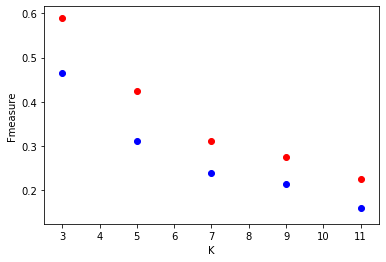

In [82]:
plotFmeasure(fScore)

Comment On Fmeasure accuracy decreases increasing the number of clusters

**Conditional Entropy**

In [83]:

true_ =kmeanClustered[0].flatten()
prediction_ = arr_gt[0][0].flatten()
cont = contingency_matrix(prediction_, true_)
contingency = cont.T
# print(contingency)

ni = np.sum(contingency,axis =1)
n = np.sum(ni)
# print(ni,n)

count = 0
centroids_entropy = []

for i in contingency:
    # -(n(i,j)/ni)log(n(i,j)/ni)
    c = 0
    for j in range(contingency.shape[1]):
        if i[j]/ni[count] !=0:
           c = c -(i[j]/ni[count])*np.log2(i[j]/ni[count])
    centroids_entropy.append(c)

    count +=1
entropy = 0 
for i in centroids_entropy:
    entropy +=(ni[centroids_entropy.index(i)]/n)*i
    
print("Conditional entropy For K = 3",entropy)

Conditional entropy For K = 3 0.5069962131230779


**Get 5 pictures**

For K = 3


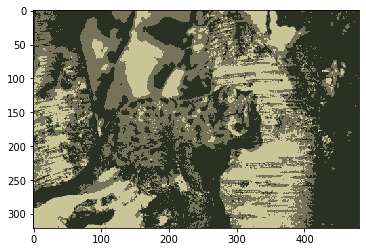

For K = 5


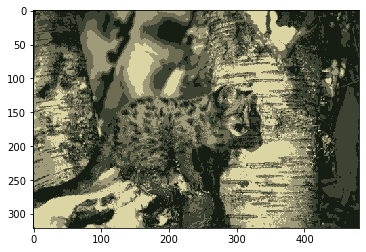

In [0]:
chsenNumbers=[46,20,14,32,7]
i_Kmean=[0,1,2,3,4]
f_Score=[]
for i in i_Kmean:
    DataKmean,data_final_clusters=main_Kmeans(chsenNumbers[i])
    kmeanClustered=convertGray(DataKmean)
    testPlot_=groundTruth_path+sortedGroundTruthFile[chsenNumbers[i]]
    arr_gt=load_bsd_gt(testPlot_)
    tst_Kmean=[0,1,2,3,4]
    f=fmeasure(tst_Kmean,kmeanClustered,arr_gt)
    f_Score.append(f)
    plotFmeasure(f)

 


    

Spectural Clustering


In [0]:

imagesFile_path = "BSR/BSDS500/data/images/train/"
imagesFile = [f for f in listdir(imagesFile_path) if isfile(join(imagesFile_path, f)) and f.endswith(".jpg")]
sortedImgfiles=sorted(imagesFile)
testPlot=imagesFile_path+sortedImgfiles[22]
image = Image.open(testPlot)
image_data = np.asarray(image)
res = cv2.resize(image_data, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
smoothed=cv2.GaussianBlur(res,(7,7),0)
data_img=smoothed.reshape(-1,3)
matrix_= pairwise_distances(data_img, metric='euclidean')
affinityMatrix = []
for row in matrix_:
  for dimensions in  row:
    aff= np.exp(-0.01 * dimensions ** 2)
    affinityMatrix.append(aff)

affinityMatrix=np.array(affinityMatrix)
affinityMatrix=affinityMatrix.reshape(10000,10000)
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity="precomputed").fit(affinityMatrix)
colorsRandom = [[213, 113, 108],[0,0,0],[255,255,255],[255,51,51],[254, 237, 127],[0,255,178],[124, 210, 234],[51,51,255],[204,255,255],[139, 151, 186],[100,100,100]]
newImage = []
for k in range(0,10000):
  newImage.append(colors[clustering.labels_[k]])
  
newImage=np.array(newImage).reshape(100,100,3)
plt.imshow(newImage)
